In [2]:
import numpy as np
import transforms3d as tf
import matplotlib.pyplot as plt

In [3]:
data = np.genfromtxt('gnss-ins-sim/demo_saved_data/2023-02-07-09-46-40/gyro-0.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
acc_data = np.genfromtxt('gnss-ins-sim/demo_saved_data/2023-02-07-09-46-40/accel-0.csv', delimiter=',')
acc_data = np.delete(acc_data, (0), axis=0) 
ref_euler = np.genfromtxt('gnss-ins-sim/demo_saved_data/2023-02-07-09-46-40/ref_att_euler.csv', delimiter=',')
ref_euler = np.delete(ref_euler, (0), axis=0)
ref_pos = np.genfromtxt('gnss-ins-sim/demo_saved_data/2023-02-07-09-46-40/ref_pos.csv', delimiter=',')
ref_pos = np.delete(ref_pos, (0), axis=0)
ref_euler.shape

(8006, 3)

In [4]:
def skew(x):
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

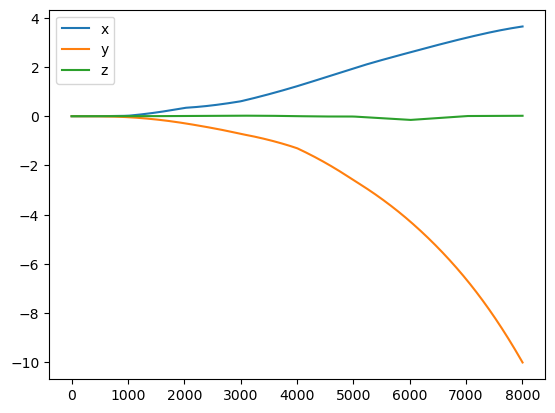

In [6]:
R_att = np.eye(3)
v = np.zeros(3)
p = ref_pos[0]
tau = 0.01
rec_err = []
rec_pos_err = []
g = np.array([0, 0, 9.794841972265039942e+00])
for i,w in enumerate(data):
    euler = np.array(tf.euler.mat2euler(R_att)) * 180 / np.pi
    error = euler - ref_euler[i]
    rec_err.append(error)
    skew_w = skew(w)
    R_att_prev = R_att.copy()
    accel = acc_data[i]
    R_att = R_att @ (np.eye(3) + skew_w * tau + .5 * skew_w**2 * tau**2)
    f = .5 * (R_att_prev + R_att) @ accel
    a = f + g
    v_prev = v.copy()
    v = v + a * tau # second order power series
    p = p +  .5 * (v + v_prev) * tau
    pos_error = p - ref_pos[i]
    rec_pos_err.append(pos_error)
plt.plot(rec_pos_err)
plt.legend(['x', 'y', 'z'])